Shape: (19251, 3)


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [01:16<00:00,  2.54s/it]


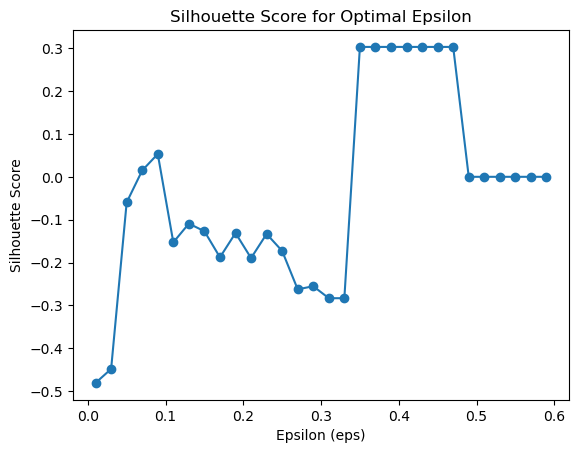

Optimal Epsilon (eps): 0.3499999999999999 with Silhouette Score: 0.30314427192244564


/Users/blaubach/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/blaubach/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


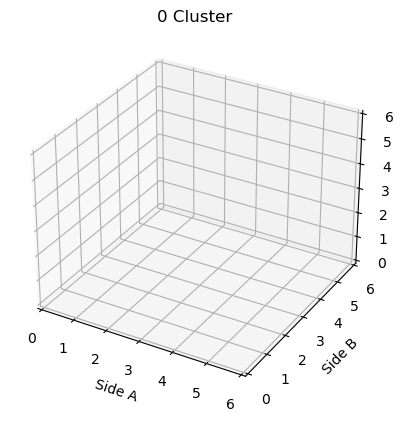

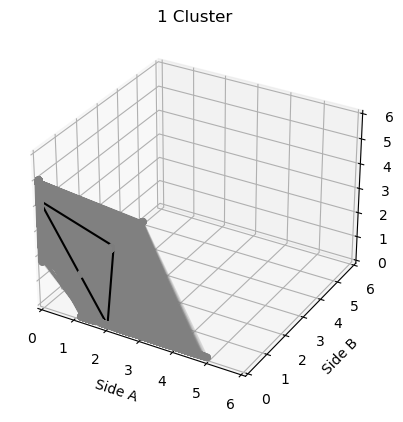

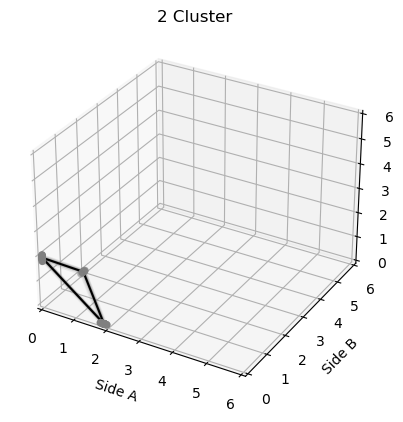

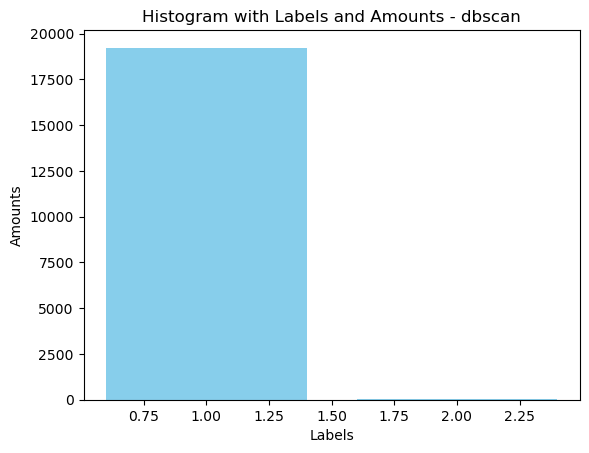

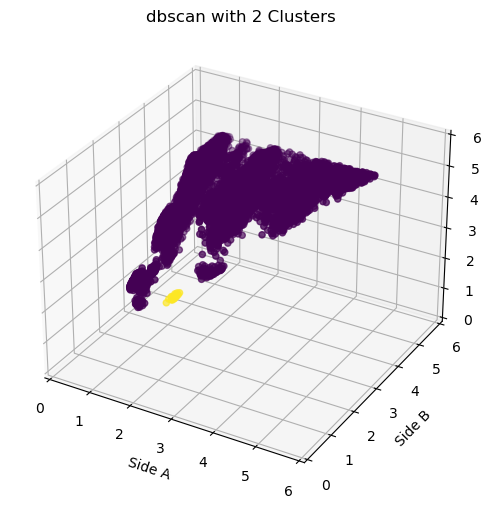

In [31]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

class ClusterVisualizer:
    def __init__(self, directory="0.5gcc_1000k_3bS/", 
                 file_range=(50, 75), 
                 clustering_method='kmeans',
                 transformation='s'):
        self.directory = directory
        self.file_range = file_range
        self.data_list = []
        self.clustering_method = clustering_method
        self.transformation = transformation

    def read_data(self, filename):
        try:
            data = np.loadtxt(filename)
            sort_data = np.sort(data, axis=1)
            self.data_list.append(sort_data)
        except FileNotFoundError:
            print(f"File not found: {filename}")

    def process_files(self):
        for i in range(*self.file_range):
            filename = f'{self.directory}00{i}.3b_clu-{self.transformation}.txt'
            self.read_data(filename)

    def visualize_clusters(self, clusters, concat_data):
        # Get the number of unique clusters
        num_clusters = len(np.unique(clusters))
        start = 0
        extra = 1

        if self.clustering_method == "hc":
            num_clusters += 1
            start = 1
            extra = 0

        if self.clustering_method == "dbscan":
            start = -1

        # Plot clusters
        for cluster_num in range(start, num_clusters):
            # Filter data points belonging to the current cluster
            selected_data = concat_data[clusters == cluster_num]

            # Create a 3D plot
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')

            # Plot individual triangles with transparent grey lines
            for i in range(len(selected_data)):
                x = [selected_data[i, 0], 0, 0]
                y = [0, selected_data[i, 1], 0]
                z = [0, 0, selected_data[i, 2]]

                # Plot points
                ax.scatter(x, y, z, marker='o', c='grey')

                # Connect the points to form a triangle with transparent grey lines
                ax.plot([x[0], x[1], x[2], x[0]], [y[0], y[1], y[2], y[0]], [z[0], z[1], z[2], z[0]], c='grey', alpha=0.1)

            # Calculate the average triangle
            average_triangle = np.mean(selected_data, axis=0)
            x_avg = [average_triangle[0], 0, 0]
            y_avg = [0, average_triangle[1], 0]
            z_avg = [0, 0, average_triangle[2]]

            # Plot the average triangle with black lines
            ax.plot(x_avg + [x_avg[0]], y_avg + [y_avg[0]], z_avg + [z_avg[0]], c='black')

            if self.transformation == "s":
                # Plot red lines along the x, y, and z axes
                ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
                ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
                ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis
                # Set axis limits to range from -1 to 1
                ax.set_xlim([-1, 1])
                ax.set_ylim([-1, 1])
                ax.set_zlim([-1, 1])
            elif self.transformation == "r":
                # Set axis limits to range from -1 to 1
                ax.set_xlim([0, 6])
                ax.set_ylim([0, 6])
                ax.set_zlim([0, 6])

            # Set axis labels
            ax.set_xlabel('Side A')
            ax.set_ylabel('Side B')
            ax.set_zlabel('Side C')

            ax.set_title(f"{cluster_num+extra} Cluster")

            # Show the plot
            plt.show()
    
    def perform_kmeans_clustering(self, concat_data, optimal_k=3):
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(concat_data)
        return labels
    
    def perform_hierarchical_clustering(self, concat_data):
        linkage_matrix = linkage(concat_data, method='average')
        dendrogram(linkage_matrix, labels=np.arange(len(concat_data)), orientation='top')

        # Choose a threshold to cut the dendrogram and form clusters
        cutoff_height = 1.0 # Adjust this value based on your dendrogram

        # Cut the dendrogram and get cluster assignments
        labels = fcluster(linkage_matrix, t=cutoff_height, criterion='distance')

        optimal_k = len(np.unique(labels))

        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.show()

        return labels, optimal_k
    
    def perform_dbscan_clustering(slef, concat_data, eps, min_samples=5):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(concat_data)
        optimal_k = len(np.unique(labels))
        return labels, optimal_k

    def plot_raw_data(self, concat_data, labels, optimal_k=3):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(concat_data[:, 0], concat_data[:, 1], concat_data[:, 2], c=labels, marker='o')
        ax.set_xlabel('Side A')
        ax.set_ylabel('Side B')
        ax.set_zlabel('Side C')
        ax.set_title(f'{self.clustering_method} with {optimal_k} Clusters')

        if self.transformation == "s":
            # Plot red lines along the x, y, and z axes
            ax.plot([-1, 1], [0, 0], [0, 0], c='red', linestyle='--', linewidth=2)  # X-axis
            ax.plot([0, 0], [-1, 1], [0, 0], c='red', linestyle='--', linewidth=2)  # Y-axis
            ax.plot([0, 0], [0, 0], [-1, 1], c='red', linestyle='--', linewidth=2)  # Z-axis
            # Set axis limits to range from -1 to 1
            ax.set_xlim([-1, 1])
            ax.set_ylim([-1, 1])
            ax.set_zlim([-1, 1])
        elif self.transformation == "r":
            # Set axis limits to range from -1 to 1
            ax.set_xlim([0, 6])
            ax.set_ylim([0, 6])
            ax.set_zlim([0, 6])

        plt.show()
        
    def plot_histogram(self, labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        unique_labels += 1
        
        # Create a bar plot
        plt.bar(unique_labels, counts, color='skyblue')

        # Add labels and title
        plt.xlabel('Labels')
        plt.ylabel('Amounts')
        plt.title(f'Histogram with Labels and Amounts - {self.clustering_method}')

        # Show the plot
        plt.show()

    def kmeans_silhouette_scores(self, concat_data):
        # Perform k-means clustering for a range of k values
        silhouette_scores = []
        k_values = range(2, 30)  # You can adjust the range of k values

        for k in tqdm(k_values):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(concat_data)
            silhouette_scores.append(silhouette_score(concat_data, clusters))

        # Find the k value with the maximum silhouette score
        optimal_k = k_values[np.argmax(silhouette_scores)]

        # Plot the Silhouette Score curve
        plt.plot(k_values, silhouette_scores, marker='o')
        plt.title('Silhouette Score for Optimal K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.show()

        return optimal_k

    def dbscan_silhouette_scores(self, concat_data):
        # Set the range of eps values
        eps_values = np.arange(0.01, 0.6, 0.02)

        # Collect silhouette scores for each eps value
        silhouette_scores = []

        # Find the optimal eps value
        optimal_eps = None
        max_silhouette_score = -1

        for eps in tqdm(eps_values):
            dbscan = DBSCAN(eps=eps, min_samples=5)
            labels = dbscan.fit_predict(concat_data)

            # Check for noise points
            if len(set(labels)) > 1:
                silhouette_score_value = silhouette_score(concat_data, labels)
                silhouette_scores.append(silhouette_score_value)

                # Update optimal_eps if the silhouette score is higher
                if silhouette_score_value > max_silhouette_score:
                    max_silhouette_score = silhouette_score_value
                    optimal_eps = eps
            else:
                silhouette_scores.append(0)

        # Plot the results
        plt.plot(eps_values, silhouette_scores, marker='o')
        plt.title('Silhouette Score for Optimal Epsilon')
        plt.xlabel('Epsilon (eps)')
        plt.ylabel('Silhouette Score')
        plt.show()

        # Print the optimal eps value
        print(f"Optimal Epsilon (eps): {optimal_eps} with Silhouette Score: {max_silhouette_score}")

        return optimal_eps

    def perform_silhouette_scores(self, concat_data):
        if self.clustering_method == 'kmeans':
            hyperparameters = self.kmeans_silhouette_scores(concat_data)
        elif self.clustering_method == 'dbscan':
            hyperparameters = self.dbscan_silhouette_scores(concat_data)

        return hyperparameters
    
    def run(self):
        self.process_files()
        concat_data = np.concatenate(self.data_list, axis=0)
        print("Shape:", np.shape(concat_data))
        
        if self.clustering_method == 'kmeans':
            # Perform k-means clustering
            optimal_k = self.perform_silhouette_scores(concat_data)
            labels = self.perform_kmeans_clustering(concat_data, optimal_k)

        elif self.clustering_method == 'hc':
            # Perform hierarchical clustering
            labels, optimal_k = self.perform_hierarchical_clustering(concat_data)

        elif self.clustering_method == 'dbscan':
            epsilon = self. perform_silhouette_scores(concat_data)
            labels, optimal_k = self.perform_dbscan_clustering(concat_data, epsilon)
            
        # Visualize clusters
        self.visualize_clusters(labels, concat_data)
        
        # Plot histogram
        self.plot_histogram(labels)

        # Plot raw data with labels
        self.plot_raw_data(concat_data, labels, optimal_k)

# Usage of the class
cluster_visualizer = ClusterVisualizer(directory="0.5gcc_1000k_3bR/",
                                       clustering_method="dbscan",
                                       transformation='r')
cluster_visualizer.run()
